# 4 author-keyword分析

本节主要分析作者与关键词之间的关系，看哪些作者偏向于研究哪些内容。统计每个a和关键词k同时出现的次数，对于每篇文章，每个作者都和每个关键词有关系。  
建立的表格是一个三维的表格：
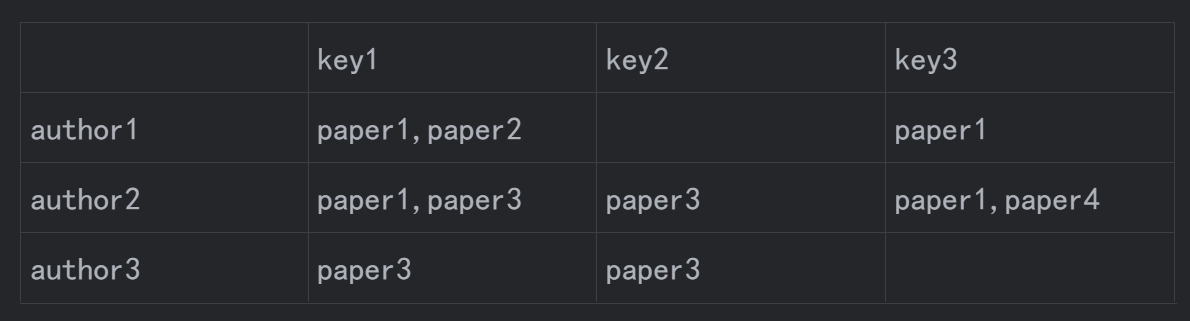
然后通过每个author中所有关键词的文章和另一个作者所有关键词的文章做交集，得到的就是这两个作者使用共同关键词合作的论文，我们只需要统计论文数量，所以取个len()：
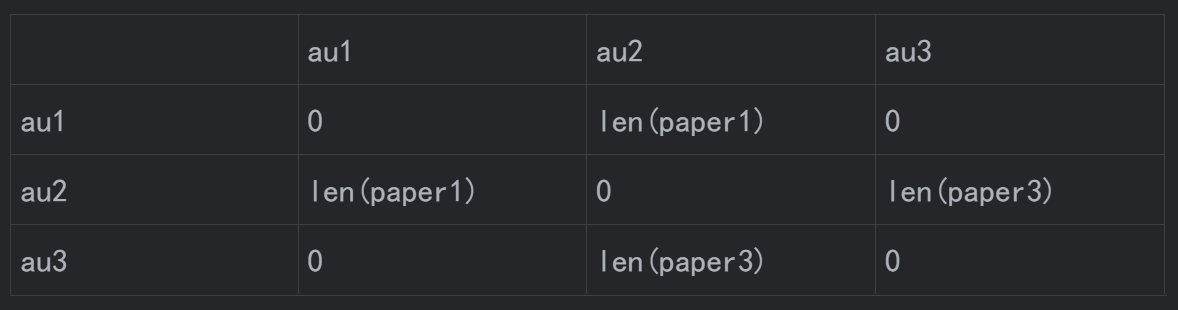
为什么使用author做行，keyword做列，是根据具体实现的考虑，因为pandas的DataFrame中的元素没办法为list或者map这种类型，所以只能使用多层的map自己实现这个数据表格了，因为以author做行，后面统计每个作者所有关键词的文章与另一个作者的交集代码上好实现。  
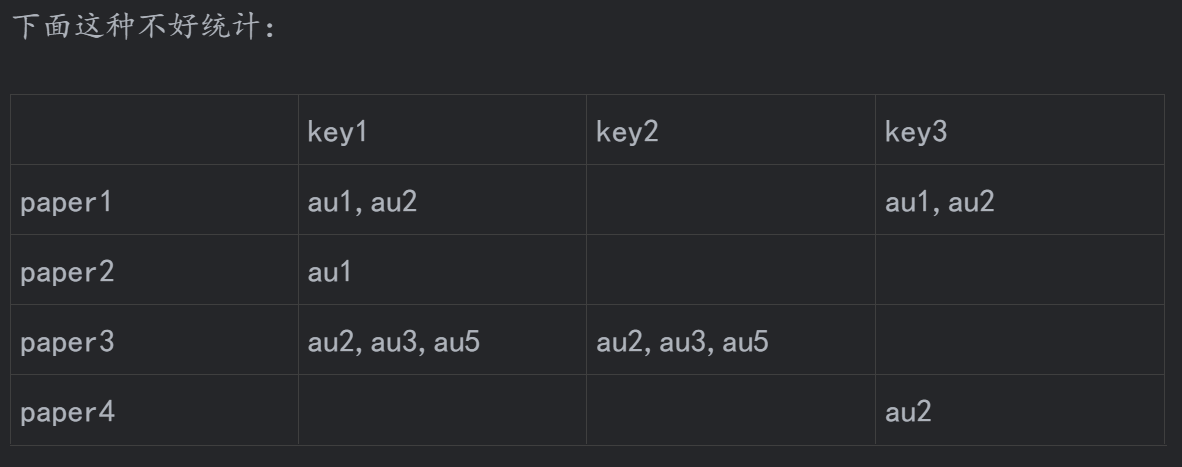
**具体实现：**
用字典的形式构造一个矩阵，行代表author，列代表keyword，元素是一个set，是author和keyword对应的文章id列表：{author:{keyword:{paper1,paper2...}}}  


## 4.1 读取数据，构造关系矩阵

In [484]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pylab
import random
import json
import re

%xmode Verbose
import warnings

# 软件包之间配套时可能会使用过时的接口，把这类告警忽略掉可以让输出信息简练一些
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 把RuntimeWarning忽略掉，不然画图的时候有太多告警了
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

Exception reporting mode: Verbose


In [485]:
# 读取原始数据
def read_json_data(filepath):
    with open(filepath, encoding='utf-8') as f:
        papers = json.load(f)
    return papers

# 过滤掉非文章的数据以及重复的文章数据
def jsondata_filter(papers, years = (0)):
    papers_list = [] # 存储过滤后的结果
    doi_set = set()
    for paper in papers: 
        title = paper['doi']
        if paper['author_keyword'] != '' and title not in doi_set: # 通过author_keyword是否为空来判断是否是一篇文章
            if years == 0 or int(paper['publication_date'][-4:]) in years: # 过滤年份
                papers_list.append(paper)
                doi_set.add(title)
        else:
            print(paper)
    return papers_list, doi_set
        

In [486]:
papers = read_json_data('./data.json')
filtered_papers, doi_set = jsondata_filter(papers, years=(2019,2020,2021,2022,2023)) # 2019,2020,2021,2022,2023
len(papers),len(filtered_papers) # 统计发现author_keyword为空的文章要么是作者介绍的pdf，要么是书信，所以这部分都该去除

{'article_title': 'IEEE Transactions on Intelligent Vehicles New Associate Editors', 'doi': '10.1109/TIV.2020.2971900', 'publication_date': 'March 2020', 'abstract': 'Presents the introductory editorial for this issue of the publication.', 'start_page': '1', 'end_page': '3', 'pages': '1_3', 'download_count': 354, 'article_content_type': 'Journals', 'publication_title': 'IEEE Transactions on Intelligent Vehicles', 'paper_link': 'https://ieeexplore.ieee.org/document/9012068/', 'pdf_link': 'https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9012068', 'volume': '5', 'issue': '1', 'authors': [{'name': 'Wen-Hua Chen', 'author_links': 'https://ieeexplore.ieee.org/author/37088221762', 'author_affiliation': 'Known'}, {'name': 'Martin Adams', 'author_links': 'https://ieeexplore.ieee.org/author/37088213156', 'author_affiliation': 'Known'}, {'name': 'Lingxi Li', 'author_links': 'https://ieeexplore.ieee.org/author/37088215459', 'author_affiliation': 'Known'}, {'name': 'Simona Onori', 'author_

(454, 330)

In [487]:
#生成文章属性列表
def gen_papers_attr(papers, attribute, sub_attribute = ''):
    papers_attr = set()

    for paper in papers:
        attrs = paper[attribute]
        for item in attrs:
            if isinstance(item, dict): # 如果是map （如authors）
                if item[sub_attribute] not in papers_attr:
                    papers_attr.add(item[sub_attribute])
            elif isinstance(item, str): # 如果是str （如author_keyword）
                if item not in papers_attr:
                    papers_attr.add(item)
    return papers_attr

In [488]:
author_keyword = gen_papers_attr(filtered_papers, 'author_keyword')
author_name = gen_papers_attr(filtered_papers, 'authors', 'name')
len(author_keyword), len(author_name)

(1169, 1141)

In [489]:
author_keyword, abbr_all, all_abbr = author_keyword_process(author_keyword)
len(author_keyword)

1072

In [462]:
# # 创建关系矩阵，可以按照不同年份统计
# def create_author_keywords_matrix(papers, doi_set, names, keywords, abbr_all, all_abbr, years = (0)): # year是一个元组，默认所有年份
#     # 1. 构造一个空的矩阵，行代表paper，列代表不同的keyword
#     matrix_zeros = np.zeros([len(keywords), len(names)])
    
#     table = pd.DataFrame(matrix_zeros, columns=names, index=keywords, dtype=int)
    
#     # 2. 填充table
#     for paper in papers:
#         if years == 0 or int(paper['publication_date'][-4:]) in years:
#             author_keywords = paper['author_keyword']
#             author_names = [item['name'] for item in paper['authors']]
#             for word in author_keywords:
#                 for name in author_names:
#                     word = word.capitalize() # 变为仅首字母大写
#                     p = re.compile(r'[(](.*?)[)]', re.S)
#                     abbr = re.findall(p, word) # 提取缩写，返回一个列表是字符串中所有的缩写，比如['RNN', 'LSTM']
#                     if len(abbr) != 0:
#                         word = re.sub(p, '', word).strip() # 删除缩写后的字符串
#                         word = ' '.join(word.split()) # 先拆分再合并，目的是合并字符串中间多余的空格

#                         if word.lower() in abbr_all.keys():
#                             table.loc[word.upper(), name] = 1
#                         elif word.lower() in all_abbr.keys():
#                             table.loc[all_abbr[word.lower()].upper(), name] = 1

#                     else:
#                         if word.lower() in abbr_all.keys():
#                             table.loc[word.upper(), name] = 1
#                         elif word.lower() in all_abbr.keys():
#                             table.loc[all_abbr[word.lower()].upper(), name] = 1
#                         else:
#                             table.loc[word, name] = 1
                
        
# #     table_value = table.values[:]
#     print(f'table=\n{table}, shape={table.shape}')
#     return table

In [588]:
# 创建关系矩阵，可以按照不同年份统计
def create_author_keywords_matrix(papers, doi_set, names, keywords, abbr_all, all_abbr, years = (0)): # year是一个元组，默认所有年份
    # 1. 用字典的形式构造一个矩阵，行代表author，列代表keyword，
    # 元素是一个set，是author和keyword对应的文章id列表：{author:{keyword:{paper1,paper2...}}}
    data_map = {}
    
    # 2. 填充table
    for paper in papers:
        if years == 0 or int(paper['publication_date'][-4:]) in years:
            author_keywords = paper['author_keyword']
            author_names = [item['name'] for item in paper['authors']]
            paper_doi = paper['doi']
            for word in author_keywords:
                for name in author_names:
                    word = word.capitalize() # 变为仅首字母大写
                    p = re.compile(r'[(](.*?)[)]', re.S)
                    abbr = re.findall(p, word) # 提取缩写，返回一个列表是字符串中所有的缩写，比如['RNN', 'LSTM']
                    
                    if len(abbr) != 0:
                        word = re.sub(p, '', word).strip() # 删除缩写后的字符串
                        word = ' '.join(word.split()) # 先拆分再合并，目的是合并字符串中间多余的空格

                        if word.lower() in abbr_all.keys():
                            if name not in data_map: # 判断是否已经加入到了字典中
                                tmp_map = {}
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                tmp_map[word.upper()] = tmp_set
                                data_map[name] = tmp_map
                            elif word.upper() not in data_map[name]:
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                data_map[name][word.upper()] = tmp_set
                            else:
                                data_map[name][word.upper()].add(paper_doi) 
                            # table.loc[word.upper(), name] = 1
                        elif word.lower() in all_abbr.keys():
                            if name not in data_map: # 判断是否已经加入到了字典中
                                tmp_map = {}
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                tmp_map[all_abbr[word.lower()].upper()] = tmp_set
                                data_map[name] = tmp_map
                            elif all_abbr[word.lower()].upper() not in data_map[name]:
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                data_map[name][all_abbr[word.lower()].upper()] = tmp_set
                            else:
                                data_map[name][all_abbr[word.lower()].upper()].add(paper_doi) 
#                             table.loc[all_abbr[word.lower()].upper(), name] = 1

                    else:
                        if word.lower() in abbr_all.keys():
                            if name not in data_map: # 判断是否已经加入到了字典中
                                tmp_map = {}
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                tmp_map[word.upper()] = tmp_set
                                data_map[name] = tmp_map
                            elif word.upper() not in data_map[name]:
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                data_map[name][word.upper()] = tmp_set
                            else:
                                data_map[name][word.upper()].add(paper_doi) 
                
#                             table.loc[word.upper(), name] = 1
                        elif word.lower() in all_abbr.keys():
                            if name not in data_map: # 判断是否已经加入到了字典中
                                tmp_map = {}
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                tmp_map[all_abbr[word.lower()].upper()] = tmp_set
                                data_map[name] = tmp_map
                            elif all_abbr[word.lower()].upper() not in data_map[name]:
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                data_map[name][all_abbr[word.lower()].upper()] = tmp_set
                            else:
                                data_map[name][all_abbr[word.lower()].upper()].add(paper_doi) 
#                             table.loc[all_abbr[word.lower()].upper(), name] = 1
                        else:
                            if name not in data_map: # 判断是否已经加入到了字典中
                                tmp_map = {}
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                tmp_map[word] = tmp_set
                                data_map[name] = tmp_map
                            elif word not in data_map[name]:
                                tmp_set = set()
                                tmp_set.add(paper_doi)
                                data_map[name][word] = tmp_set
                            else:
                                data_map[name][word].add(paper_doi) 
#                             table.loc[word, name] = 1
                
    
    # 直接根据统计的data_map计算author-keyword关系矩阵
    matrix_zeros = np.zeros([len(names), len(names)])
    
    table = pd.DataFrame(matrix_zeros, columns=names, index=names, dtype=int)
    
    for name_1 in data_map.keys():
        num_of_paper = 0
        big_set_1 = set()
        for keyword in data_map[name_1].keys():
                big_set_1 = big_set_1.union(data_map[name_1][keyword])
        for name_2 in data_map.keys():
            big_set_2 = set()
            for keyword in data_map[name_2].keys():
                big_set_2 = big_set_2.union(data_map[name_2][keyword])
                
            num_of_paper = len(big_set_1.intersection(big_set_2))
            table.loc[name_1, name_2] = num_of_paper
#             table.loc[name_2, name_1] = num_of_paper
            
        
    
#     table_value = table.values[:]
    print(f'table=\n{data_map}')
    return table

In [589]:
%%time
table = create_author_keywords_matrix(filtered_papers, doi_set, author_name, author_keyword, abbr_all, all_abbr) # 这里不设置年份了，因为在上面读取数据的时候就把年份过滤了

table=
{'Stephanie Cramer': {'Automated driving': {'10.1109/TIV.2018.2886691', '10.1109/TIV.2022.3161570'}, 'Partial automation': {'10.1109/TIV.2018.2886691'}, 'Mode awareness': {'10.1109/TIV.2018.2886691'}, 'Feedback for the driver': {'10.1109/TIV.2018.2886691'}, 'Active pitch motions': {'10.1109/TIV.2018.2886691'}, 'User interface': {'10.1109/TIV.2018.2886691'}, 'Conditional automation': {'10.1109/TIV.2022.3161570'}, 'Lane changes': {'10.1109/TIV.2022.3161570'}, 'Driving study': {'10.1109/TIV.2022.3161570'}}, 'Ina Kaup': {'Automated driving': {'10.1109/TIV.2018.2886691'}, 'Partial automation': {'10.1109/TIV.2018.2886691'}, 'Mode awareness': {'10.1109/TIV.2018.2886691'}, 'Feedback for the driver': {'10.1109/TIV.2018.2886691'}, 'Active pitch motions': {'10.1109/TIV.2018.2886691'}, 'User interface': {'10.1109/TIV.2018.2886691'}}, 'Karl-Heinz Siedersberger': {'Automated driving': {'10.1109/TIV.2018.2886691'}, 'Partial automation': {'10.1109/TIV.2018.2886691'}, 'Mode awareness': {'10.1109

In [492]:
table_value = table.values[:]
author_number_of_keyword = table_value.sum(axis=0)
sorted(author_number_of_keyword, reverse=True)

[69,
 54,
 52,
 46,
 43,
 27,
 26,
 26,
 26,
 24,
 24,
 20,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 

In [440]:
# def author_keywords_matrix_frequency_n_filter(table, n): # 过滤出频率大于n的
#     table_value = table.values[:]
#     frequency = table_value.sum(axis=0)

#     bool_arr = np.array(frequency) > n
    
#     index_arr = []
#     for i in range(len(bool_arr)):
#         if not bool_arr[i]:
#             index_arr.append(i)
    
#     table = table.drop(table.columns[index_arr], axis = 1) # 删除不满足条件的列 
    
#     return  table

In [441]:
# table = author_keywords_matrix_frequency_n_filter(table, 6) # 9
# table

Shiqi Tang  Danil Prokhorov  Zhongxu Hu  Keiji Aoki  \
Rui Wang                       0                0           0           0   
Shiqi Tang                     2                0           0           0   
Christian Pek                  0                0           0           0   
Yanbing Wang                   0                0           0           0   
Cagdas Yaman                   0                0           0           0   
...                          ...              ...         ...         ...   
Changxin Zhou                  0                0           0           0   
Yongqiang Wang                 0                0           0           0   
Yijie Yu                       0                0           0           0   
Suneel Kumar Kommuri           0                0           0           0   
Huaxin Pei                     0                0           0           0   

                      BaekGyu Kim  Hong Chen  Rui Zhou  Byron Mason  \
Rui Wang                        0          0         0            0   
Shiqi Tang                      0          0         0            0   
Christian Pek                   0          0         0            0   
Yanbing Wang                    0          0         0            0   
Cagdas Yaman                    0          0         0            0   
...                           ...        ...       ...          ...   
Changxin Zhou                   0          0         0            0   
Yongqiang Wang                  0          0         0            0   
Yijie Yu                        0          0         0            0   
Suneel Kumar Kommuri            0          0         0            0   
Huaxin Pei                      0          0         0            0   

                      Yuanyuan Chen  Björn Klamann  ...  Stanley Chien  \
Rui Wang                          0              0  ...              0   
Shiqi Tang                        0              0  ...              0   
Christian Pek                     0              0  ...              0   
Yanbing Wang                      0              0  ...              0   
Cagdas Yaman                      0              0  ...              0   
...                             ...            ...  ...            ...   
Changxin Zhou                     0              0  ...              0   
Yongqiang Wang                    0              0  ...              0   
Yijie Yu                          0              0  ...              0   
Suneel Kumar Kommuri              0              0  ...              0   
Huaxin Pei                        0              0  ...              0   

                      Inga Jatzkowski  Tianyu Shen  Ekim Yurtsever  \
Rui Wang                            0            0               0   
Shiqi Tang                          0            0               0   
Christian Pek                       0            0               0   
Yanbing Wang                        0            0               0   
Cagdas Yaman                        0            0               0   
...                               ...          ...             ...   
Changxin Zhou                       0            0               0   
Yongqiang Wang                      0            0               0   
Yijie Yu                            0            0               0   
Suneel Kumar Kommuri                0            0               0   
Huaxin Pei                          0            0               0   

                      Yuxuan Xia  Stefano Di Cairano  Yuchen Li  \
Rui Wang                       0                   0          0   
Shiqi Tang                     0                   0          0   
Christian Pek                  0                   0          0   
Yanbing Wang                   0                   0          0   
Cagdas Yaman                   0                   0          0   
...                          ...                 ...        ...   
Changxin Zhou                  0             

In [239]:
# # 这里重新统计一下列名，因为删除了一些列
# author_keyword = table.columns.values
# len(author_keyword), author_keyword

(79,
 array(['Zhongxu Hu', 'Michele Segata', 'Rui Zhou', 'Fei-Yue Wang',
        'Dariu M. Gavrila', 'Chen Lv', 'Matthias Althoff', 'Jeroen Ploeg',
        'Victor Fors', 'Yang Xing', 'J. Christian Gerdes', 'Shen Li',
        'Yunfeng Ai', 'Prashant Tiwari', 'Malte Probst', 'Kai Huang',
        'Alexander Brunker', 'Mehrdad Dianati', 'Alexander Wischnewski',
        'Yang Li', 'Xiao Wang', 'Haiping Du', 'Li Wang', 'Kohei Sonoda',
        'Thomas Wohlgemuth', 'Yi Lu Murphey', 'Keqiang Li', 'Dongpu Cao',
        'Akshay Rangesh', 'Daqi Zhu', 'Houshyar Asadi', 'Ziran Wang',
        'Björn Olofsson', 'Takayuki Ando', 'Guoyuan Wu', 'Joe Khalife',
        'Yutong Wang', 'Tim Puphal', 'Xinglong Zhang', 'Pinar Boyraz',
        'Jiangong Wang', 'Takahiro Wada', 'Hermann Winner', 'Liang Li',
        'Erik Frisk', 'Lei Yang', 'Junmin Wang', 'Frank Gauterin',
        'Xiaohua Ge', 'Ryan Gerdes', 'Julian F. P. Kooij',
        'Kimihiko Nakano', 'Saeid Nahavandi', 'Rajnikant Sharma',
        'Michae

In [453]:
# author_keyword = table.columns.values

In [493]:
# 画图初始化
def draw_graph_init(table, labels):
    table_value = table.values[:]
#     matrix_coword = np.dot(np.transpose(table_value),table_value)
    matrix_coword = table_value
    print(f'matrix_coword.shape = {matrix_coword.shape}')
    np.fill_diagonal(matrix_coword, 0) # 主对角线填充0
    # 计算每个节点的度
#     nodes_degree = matrix_coword.sum(axis=0) # 暂时还没用到这个度，先注释了
    
    graph_co_word_matrix = nx.from_numpy_array(matrix_coword)
    print(nx.info(graph_co_word_matrix))
    
    # 为节点添加标签
    coword_labels = nx.get_node_attributes(graph_co_word_matrix, 'labels') # 此时的coword_labels为空{}
    list_labels = list(labels)
    for idx, node in enumerate(graph_co_word_matrix.nodes()): 
#         print("idx=", idx, "; node=", node)
        coword_labels[node] = list_labels[idx]
    graph_co_word_matrix = nx.relabel_nodes(graph_co_word_matrix, coword_labels)
    
    return graph_co_word_matrix
    

In [494]:

graph_co_word_matrix = draw_graph_init(table, author_name)

matrix_coword.shape = (1141, 1141)
Graph with 1141 nodes and 2434 edges


## 4.2 绘制整个数据

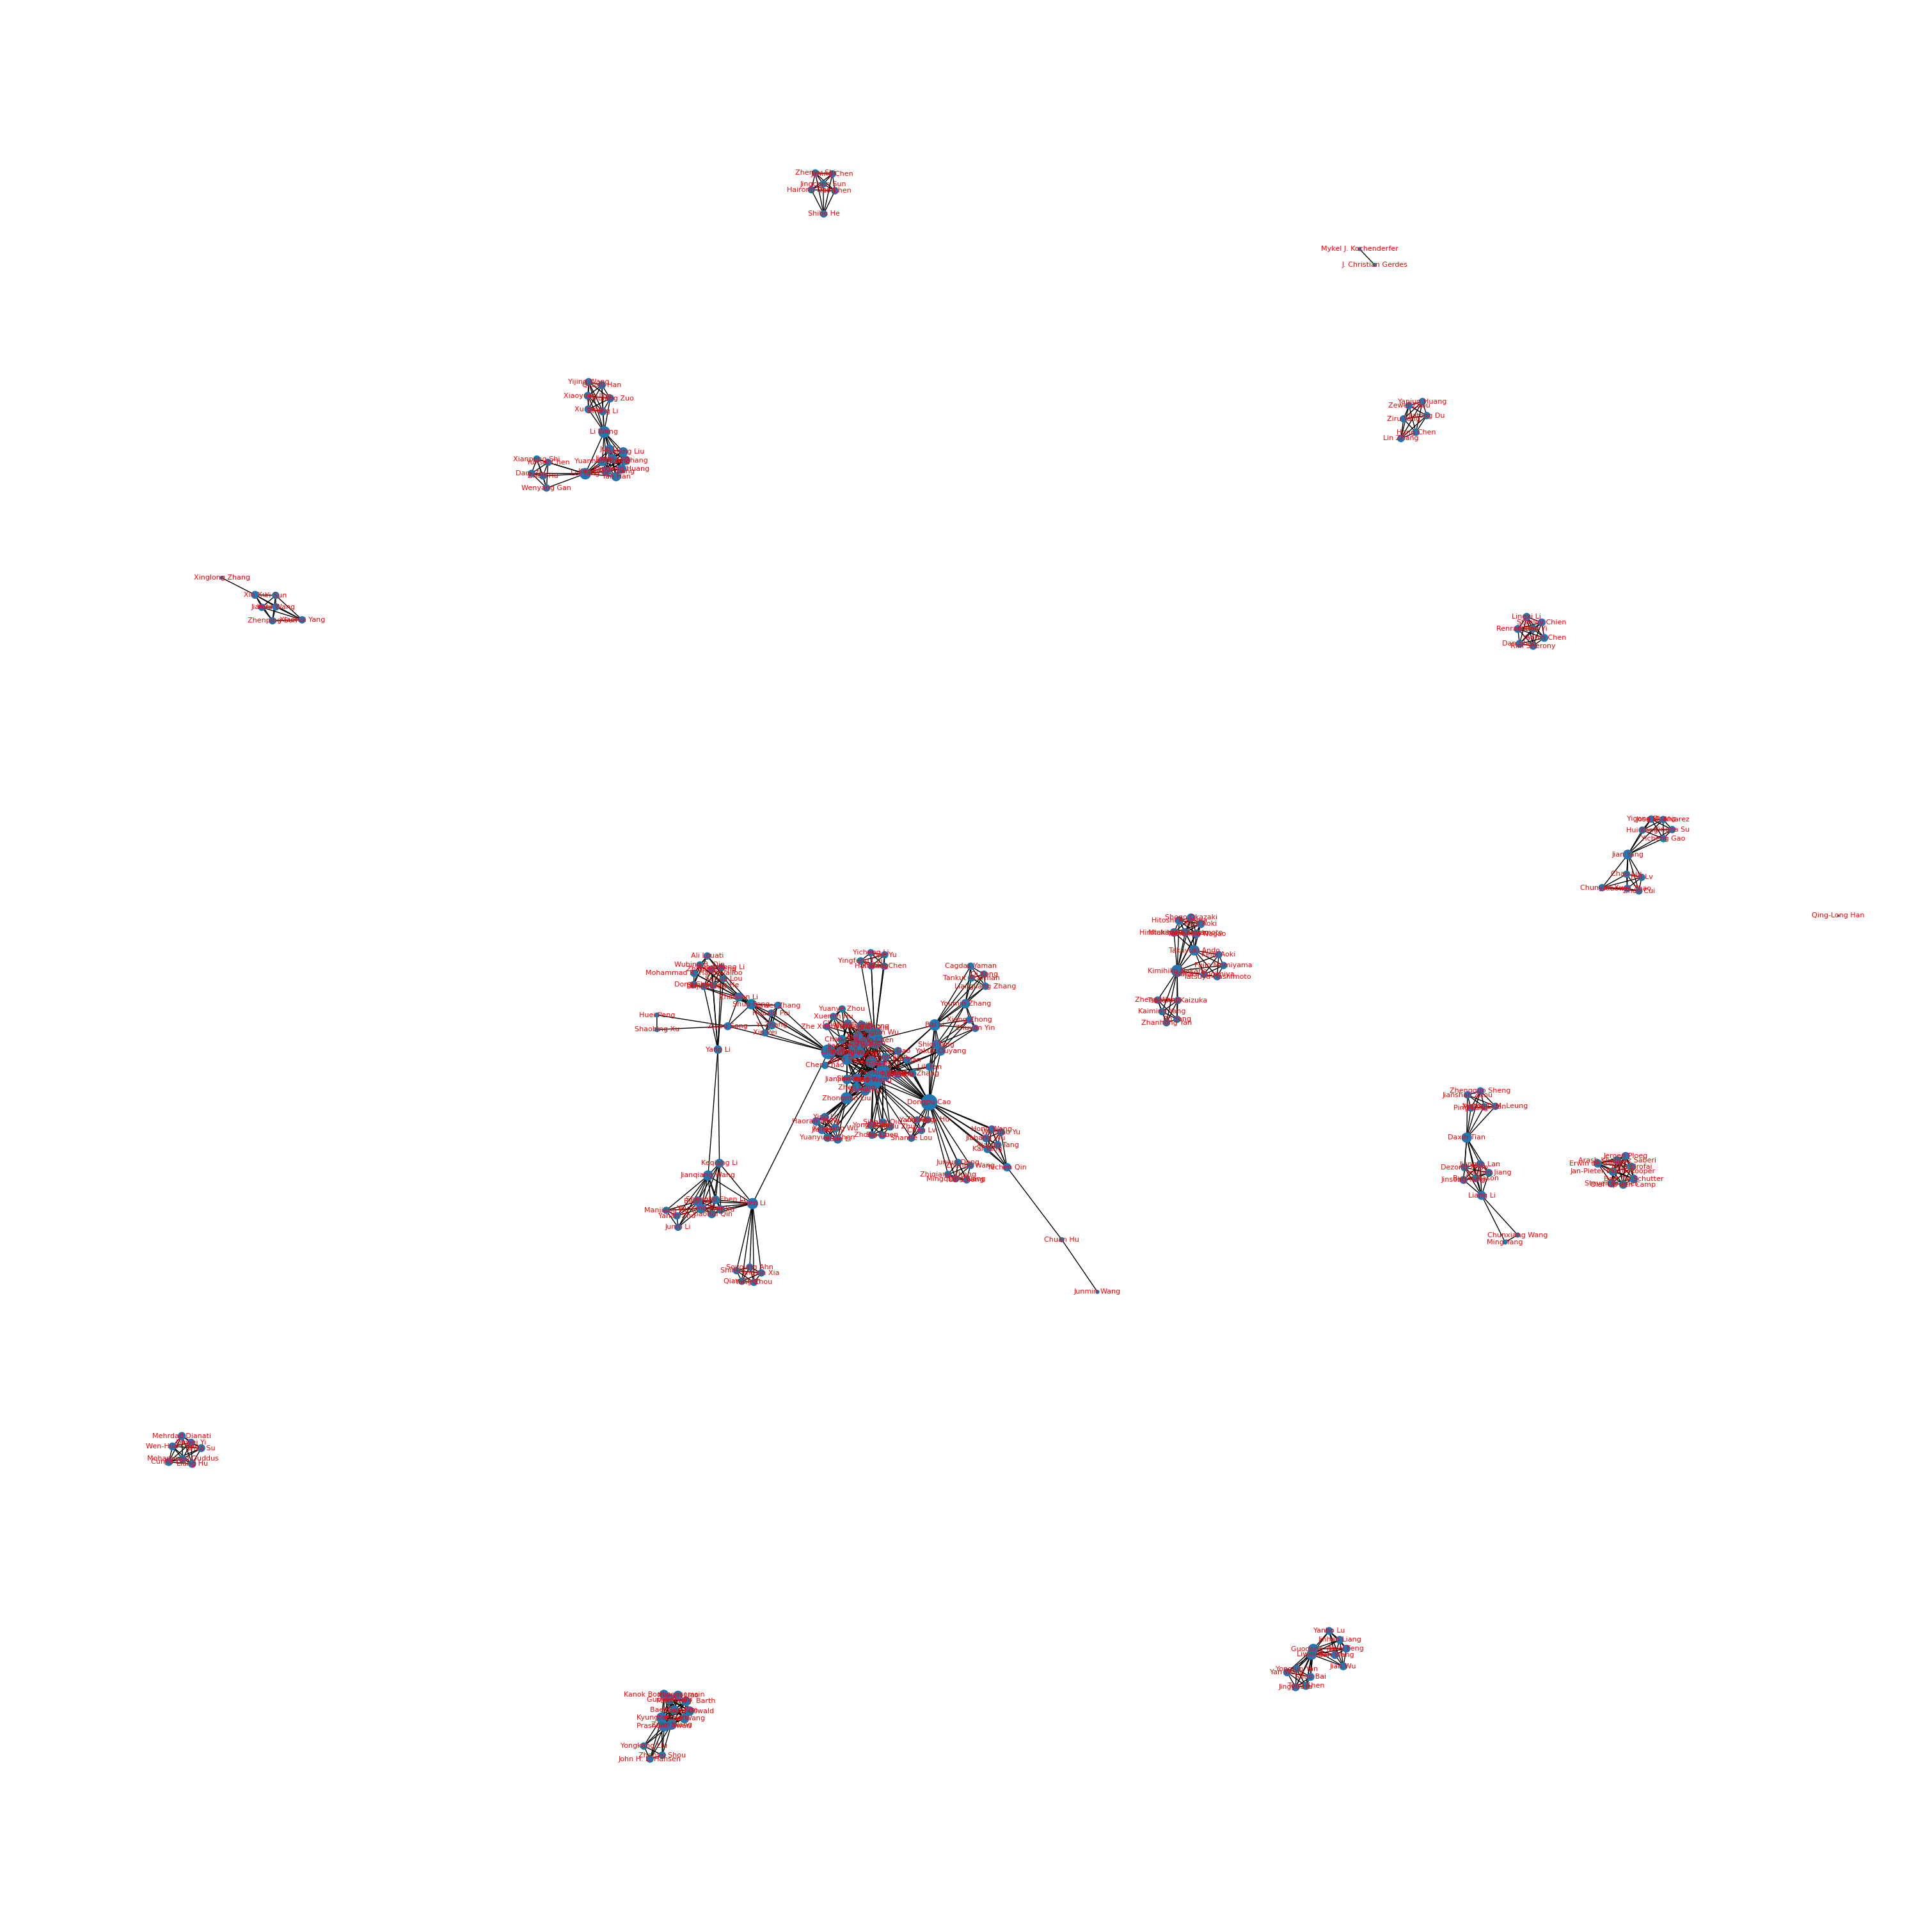

In [506]:
pos = nx.spring_layout(graph_co_word_matrix)
plt.figure(1, figsize=(30,30),dpi=100)

node_size = [val for (node, val) in graph_co_word_matrix.degree()]
node_size = [3 + 10 * i for i in node_size]
nx.draw(graph_co_word_matrix, pos, node_size=node_size, with_labels=True, font_size=8, font_color="red")

In [476]:
graph_co_word_matrix_1 = graph_co_word_matrix

In [496]:
nx.number_connected_components(graph_co_word_matrix)
components_list = []
for i in list(nx.connected_components(graph_co_word_matrix)):
#     print(type(i))
    if len(i) < 10:
        graph_co_word_matrix.remove_nodes_from(list(i))
nx.number_connected_components(graph_co_word_matrix)

<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class

15

In [502]:
sorted(graph_co_word_matrix.degree(), key = lambda x:x[1], reverse=True)

[('Xiao Wang', 44),
 ('Dongpu Cao', 38),
 ('Long Chen', 35),
 ('Fei-Yue Wang', 32),
 ('Li Li', 30),
 ('Yunfeng Ai', 17),
 ('Kimihiko Nakano', 17),
 ('Bai Li', 17),
 ('Shen Li', 15),
 ('Zhongmin Liu', 15),
 ('Li Wang', 15),
 ('Yutong Wang', 15),
 ('Jiangong Wang', 15),
 ('Yonglin Tian', 15),
 ('Lei Yang', 14),
 ('Hui Yu', 14),
 ('Nanning Zheng', 14),
 ('Tianyu Shen', 14),
 ('Mehrdad Dianati', 13),
 ('Liang Li', 13),
 ('Prashant Tiwari', 12),
 ('Ziran Wang', 12),
 ('Xin Xu', 12),
 ('Kyungtae Han', 12),
 ('Siyu Teng', 12),
 ('Jianqiang Wang', 12),
 ('Guodong Yin', 11),
 ('Jingmin Xin', 11),
 ('Daxin Tian', 11),
 ('Xiangbin Wu', 11),
 ('Takayuki Ando', 11),
 ('Guoyuan Wu', 11),
 ('Liwei Xu', 11),
 ('Shuo Feng', 11),
 ('Yougang Bian', 10),
 ('Chen Lv', 10),
 ('Chao Gou', 10),
 ('Jian Yang', 10),
 ('Rini Sherony', 10),
 ('Biao Xu', 10),
 ('Shiqi Tang', 9),
 ('BaekGyu Kim', 9),
 ('Hong Chen', 9),
 ('Rui Zhou', 9),
 ('Kangyao Huang', 9),
 ('Jianxi Luo', 9),
 ('Jeroen Ploeg', 9),
 ('Jianjian Ya

In [503]:
graph_co_word_matrix.degree()

DegreeView({'Shiqi Tang': 9, 'Cagdas Yaman': 5, 'Wentao Wu': 3, 'Ali Louati': 5, 'Zhongxu Hu': 8, 'Haichuan Gao': 4, 'Keiji Aoki': 7, 'Zewei Zhou': 5, 'BaekGyu Kim': 9, 'Liuyuan Deng': 4, 'Sarah M. Thornton': 4, 'Weihao Gu': 4, 'Hong Chen': 9, 'John K. Subosits': 1, 'Rui Zhou': 9, 'Byron Mason': 6, 'Yuanyuan Chen': 7, 'Krister Wolff': 4, 'Yifei Shi': 3, 'Kangyao Huang': 9, 'Yougang Bian': 10, 'Fei-Yue Wang': 32, 'Yang Lu': 3, 'Matthew Brown': 1, 'Chen Lv': 10, 'Jianxi Luo': 9, 'Haohan Yang': 3, 'Hitoshi Aoyama': 7, 'Ziyou Song': 8, 'Zhihuang Zhang': 3, 'Chao Gou': 10, 'Haoran Wang': 7, 'Fujio Momiyama': 5, 'Shaobing Xu': 7, 'Jeroen Ploeg': 9, 'Cunjia Liu': 6, 'Rencheng Zheng': 3, 'Yan Jiang': 3, 'Zhenyu Shou': 5, 'Yuqing Guo': 4, 'Jianjian Yang': 9, 'Yang Xing': 6, 'Junni Li': 5, 'Yimin Chen': 2, 'J. Christian Gerdes': 6, 'Chen Cui': 4, 'Yan Han': 9, 'Yuanzheng Li': 5, 'Xiaotong Zhang': 4, 'Jun Li': 9, 'Shen Li': 15, 'Wubing B. Qin': 5, 'Zhongmin Liu': 15, 'Jan-Pieter Paardekooper': 7,

In [505]:
for node, val in list(graph_co_word_matrix.degree()):
    if val < 5:
        graph_co_word_matrix.remove_node(node)


## 4.3 最大分支绘制

### 4.3.1 不划分社区

联通分支个数：1


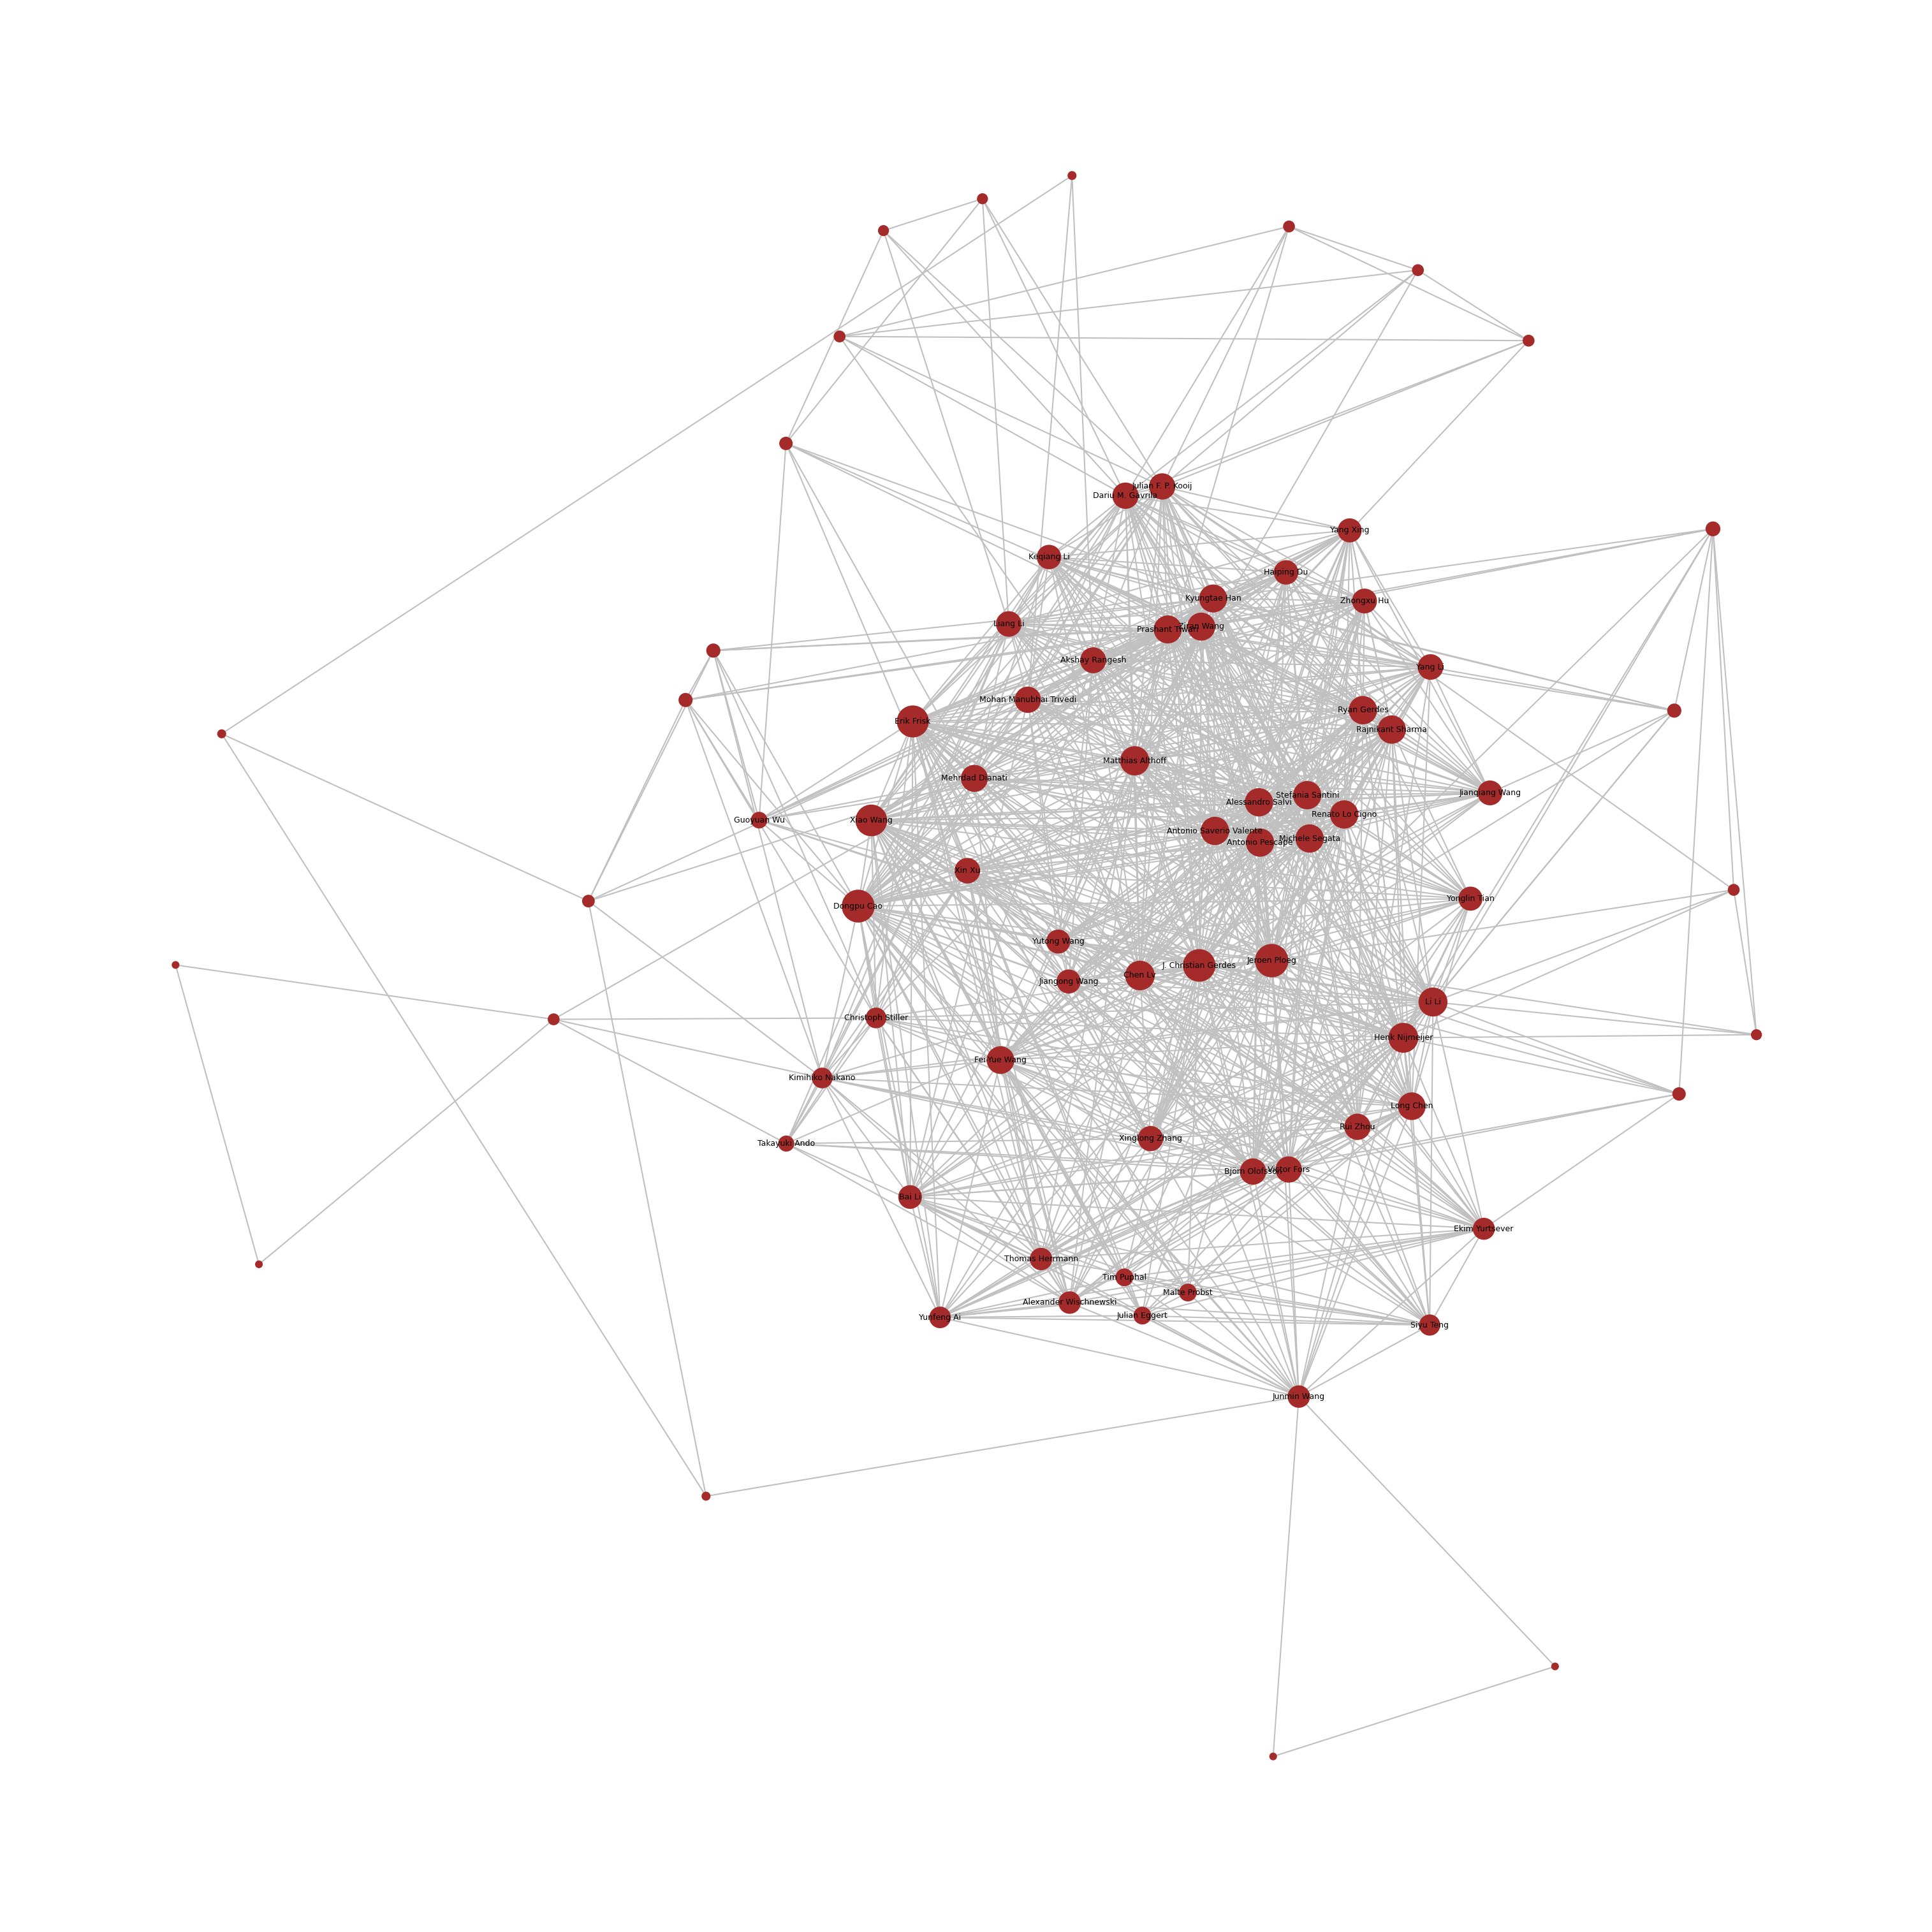

In [242]:
# 分析上面画出来的图，分析联通分支
print(f"联通分支个数：{nx.number_connected_components(graph_co_word_matrix)}")

# 获取 G 中所有的连通子图，然后找出最大的子图
components = nx.connected_components(graph_co_word_matrix)
largest = max(components,key=len)
largest_connected_subgraph = graph_co_word_matrix.subgraph(largest)


# pos = nx.spring_layout(graph_co_word_matrix)
pos = nx.kamada_kawai_layout(graph_co_word_matrix)
plt.figure(1,figsize=(20,20), dpi=150)
node_size = [val for (node, val) in largest_connected_subgraph.degree()]
node_size = [3 + 10 * i for i in node_size]

# 选择一些重要节点显示标签，其他节点不显示，这里设置节点的度大于20时显示标签
labels = {
    n: (n 
        if len(list(nx.all_neighbors(graph_co_word_matrix, n))) > 10
        else '') 
    for n in graph_co_word_matrix.nodes
}
nx.draw(largest_connected_subgraph, pos, node_size=node_size, with_labels=True, labels=labels,
        font_size=6, font_color="black", node_color='brown', edge_color='silver')
plt.show()

### 4.3.2 GN算法划分社区

In [524]:
largest_connected_subgraph = graph_co_word_matrix

In [507]:
%%time
from networkx.algorithms import community

# communities_generator = community.girvan_newman(largest_connected_subgraph.copy())
communities_generator = community.girvan_newman(graph_co_word_matrix.copy())
top_level_co_word = sorted(map(sorted, next(communities_generator)))
# top_level_co_word

Wall time: 62.5 ms


In [508]:
%%time
second_level_co_word = sorted(map(sorted, next(communities_generator)))
second_level_co_word

Wall time: 507 ms


[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Bin Chen',
  'Bin Tian',
  'Cagdas Yaman',
  'Changyin Sun',
  'Chao Gou',
  'Chen Lv',
  'Chen Zhao',
  'Chuan Hu',
  'Dongpu Cao',
  'Fangyin Tian',
  'Fei Yao',
  'Fei-Yue Wang',
  'Hai Wang',
  'Haoran Wang',
  'Hong Wang',
  'Hui Yu',
  'Jia Hu',
  'Jiahang Wu',
  'Jiangong Wang',
  'Jianjian Yang',
  'Jingmin Xin',
  'Junjun Deng',
 

In [509]:
third_level_co_word = sorted(map(sorted, next(communities_generator)))
third_level_co_word

[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Bin Chen',
  'Bin Tian',
  'Cagdas Yaman',
  'Changyin Sun',
  'Chao Gou',
  'Chen Lv',
  'Chen Zhao',
  'Dongpu Cao',
  'Fangyin Tian',
  'Fei Yao',
  'Fei-Yue Wang',
  'Hai Wang',
  'Haoran Wang',
  'Hong Wang',
  'Hui Yu',
  'Jia Hu',
  'Jiahang Wu',
  'Jiangong Wang',
  'Jianjian Yang',
  'Jingmin Xin',
  'Junjun Deng',
  'Kai Yang',
 

In [510]:
fourth_level_co_word = sorted(map(sorted, next(communities_generator)))
# fourth_level_co_word

In [511]:
fifth_level_co_word = sorted(map(sorted, next(communities_generator)))
fifth_level_co_word

[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Cagdas Yaman',
  'Liangliang Zhang',
  'Lili Fan',
  'Qi Kong',
  'Shiqi Tang',
  'Tankut Acarman',
  'Xiang Zhong',
  'Yakun Ouyang',
  'Youmin Zhang',
  'Zhuyan Yin'],
 ['Biao Xu',
  'Jianqiang Wang',
  'Jingxin Xia',
  'Junni Li',
  'Keqiang Li',
  'Leijiao Ge',
  'Manjiang Hu',
  'Qian Chen',
  'Qing Xu',
  'Shangyang He',
  'Shen Li',

In [512]:
sixth_level_co_word = sorted(map(sorted, next(communities_generator)))
sixth_level_co_word

[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Cagdas Yaman',
  'Liangliang Zhang',
  'Lili Fan',
  'Qi Kong',
  'Shiqi Tang',
  'Tankut Acarman',
  'Xiang Zhong',
  'Yakun Ouyang',
  'Youmin Zhang',
  'Zhuyan Yin'],
 ['Biao Xu',
  'Jianqiang Wang',
  'Jingxin Xia',
  'Junni Li',
  'Keqiang Li',
  'Manjiang Hu',
  'Qian Chen',
  'Qing Xu',
  'Shen Li',
  'Shengbo Eben Li',
  'Shihua Li

In [513]:
%%time
seventh_level_co_word = sorted(map(sorted, next(communities_generator)))
seventh_level_co_word

Wall time: 142 ms


[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Cagdas Yaman',
  'Liangliang Zhang',
  'Lili Fan',
  'Qi Kong',
  'Shiqi Tang',
  'Tankut Acarman',
  'Xiang Zhong',
  'Yakun Ouyang',
  'Youmin Zhang',
  'Zhuyan Yin'],
 ['Biao Xu',
  'Jianqiang Wang',
  'Jingxin Xia',
  'Junni Li',
  'Keqiang Li',
  'Manjiang Hu',
  'Qian Chen',
  'Qing Xu',
  'Shen Li',
  'Shengbo Eben Li',
  'Shihua Li

In [514]:
%%time
eighth_level_co_word = sorted(map(sorted, next(communities_generator)))
eighth_level_co_word

Wall time: 315 ms


[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Cagdas Yaman',
  'Liangliang Zhang',
  'Lili Fan',
  'Qi Kong',
  'Shiqi Tang',
  'Tankut Acarman',
  'Xiang Zhong',
  'Yakun Ouyang',
  'Youmin Zhang',
  'Zhuyan Yin'],
 ['Biao Xu',
  'Jianqiang Wang',
  'Jingxin Xia',
  'Junni Li',
  'Keqiang Li',
  'Manjiang Hu',
  'Qian Chen',
  'Qing Xu',
  'Shen Li',
  'Shengbo Eben Li',
  'Shihua Li

In [515]:
%%time
ninth_level_co_word = sorted(map(sorted, next(communities_generator)))
ninth_level_co_word

Wall time: 294 ms


[['Ali Louati',
  'Dong Chen',
  'Huaxin Pei',
  'Huei Peng',
  'Jiawei Zhang',
  'Mohammad R. Hajidavalloo',
  'Shaobing Xu',
  'Shuo Feng',
  'Wubing B. Qin',
  'Xin Pei',
  'Yi Zhang',
  'Zhaojian Li',
  'Ziyou Song'],
 ['Arash Khabbaz Saberi',
  'Bart De Schutter',
  'Erwin de Gelder',
  'Hala Elrofai',
  'Jan-Pieter Paardekooper',
  'Jeroen Ploeg',
  'Olaf Op den Camp',
  'Steven Kraines'],
 ['BaekGyu Kim',
  'Chao Wang',
  'David Oswald',
  'Guoyuan Wu',
  'John H. L. Hansen',
  'Kanok Boriboonsomsin',
  'Kyungtae Han',
  'Matthew J. Barth',
  'Prashant Tiwari',
  'Xishun Liao',
  'Yongkang Liu',
  'Zhenyu Shou',
  'Ziran Wang'],
 ['Bai Li',
  'Cagdas Yaman',
  'Liangliang Zhang',
  'Lili Fan',
  'Qi Kong',
  'Shiqi Tang',
  'Tankut Acarman',
  'Xiang Zhong',
  'Yakun Ouyang',
  'Youmin Zhang',
  'Zhuyan Yin'],
 ['Biao Xu',
  'Jianqiang Wang',
  'Jingxin Xia',
  'Junni Li',
  'Keqiang Li',
  'Manjiang Hu',
  'Qian Chen',
  'Qing Xu',
  'Shen Li',
  'Shengbo Eben Li',
  'Shihua Li

In [565]:
largest_subgraph_nodes_degree = list(nx.degree(largest_connected_subgraph))
largest_subgraph_nodes_degree

[('Shiqi Tang', 9),
 ('Cagdas Yaman', 5),
 ('Ali Louati', 5),
 ('Zhongxu Hu', 5),
 ('Keiji Aoki', 7),
 ('Zewei Zhou', 5),
 ('BaekGyu Kim', 9),
 ('Hong Chen', 5),
 ('Rui Zhou', 6),
 ('Byron Mason', 6),
 ('Yuanyuan Chen', 7),
 ('Kangyao Huang', 9),
 ('Yougang Bian', 10),
 ('Fei-Yue Wang', 32),
 ('Chen Lv', 5),
 ('Jianxi Luo', 9),
 ('Hitoshi Aoyama', 7),
 ('Ziyou Song', 6),
 ('Chao Gou', 8),
 ('Haoran Wang', 7),
 ('Fujio Momiyama', 5),
 ('Shaobing Xu', 2),
 ('Jeroen Ploeg', 7),
 ('Cunjia Liu', 6),
 ('Zhenyu Shou', 5),
 ('Jianjian Yang', 9),
 ('Yang Xing', 5),
 ('Junni Li', 5),
 ('J. Christian Gerdes', 1),
 ('Yan Han', 9),
 ('Yuanzheng Li', 5),
 ('Jun Li', 9),
 ('Shen Li', 13),
 ('Wubing B. Qin', 5),
 ('Zhongmin Liu', 15),
 ('Jan-Pieter Paardekooper', 7),
 ('Bo Yang', 5),
 ('Yunfeng Ai', 15),
 ('Shengbo Eben Li', 7),
 ('Jiwei Feng', 6),
 ('Yanbo Lu', 6),
 ('Xiaoyuan Luo', 6),
 ('Bin Chen', 6),
 ('Mykel J. Kochenderfer', 1),
 ('Yu Gao', 6),
 ('Hui Kong', 5),
 ('Kai Yang', 6),
 ('Xin Pei', 5

In [566]:
# 对third_level_co_word划分中，每个子集的节点按照度数排序
sub_degree_list = [] # 存放排序结果
for sub_list in seventh_level_co_word:
    sub_degree_map = dict()
    for i in largest_subgraph_nodes_degree:
        if i[0] in sub_list:
            sub_degree_map[i[0]] = i[1]
    tmp = sorted(sub_degree_map.items(), key = lambda x:x[1], reverse=True)
    sub_degree_list.append(tmp)

for item in sub_degree_list:
    for index in range(len(item)):
        if index > 5:
            break
        print(item[index])
    print('==============')

('Shuo Feng', 11)
('Zhaojian Li', 8)
('Yi Zhang', 7)
('Ziyou Song', 6)
('Ali Louati', 5)
('Wubing B. Qin', 5)
('Jeroen Ploeg', 7)
('Jan-Pieter Paardekooper', 7)
('Bart De Schutter', 7)
('Erwin de Gelder', 7)
('Olaf Op den Camp', 7)
('Hala Elrofai', 7)
('Prashant Tiwari', 12)
('Ziran Wang', 12)
('Kyungtae Han', 12)
('BaekGyu Kim', 9)
('Matthew J. Barth', 9)
('Guoyuan Wu', 9)
('Bai Li', 14)
('Shiqi Tang', 9)
('Youmin Zhang', 9)
('Yakun Ouyang', 9)
('Lili Fan', 6)
('Cagdas Yaman', 5)
('Shen Li', 13)
('Jianqiang Wang', 11)
('Yougang Bian', 10)
('Biao Xu', 10)
('Keqiang Li', 8)
('Shengbo Eben Li', 7)
('Xiao Wang', 42)
('Long Chen', 33)
('Fei-Yue Wang', 32)
('Li Li', 25)
('Zhongmin Liu', 15)
('Yunfeng Ai', 15)
('Kimihiko Nakano', 16)
('Takayuki Ando', 11)
('Keiji Aoki', 7)
('Hitoshi Aoyama', 7)
('Michiharu Yamamoto', 7)
('Hirotaka Mukumoto', 7)
('Daxin Tian', 11)
('Liang Li', 8)
('Byron Mason', 6)
('Jinsong Yang', 6)
('Dezong Zhao', 6)
('Jianglin Lan', 6)
('Jian Yang', 10)
('Hui Kong', 5)
('

In [585]:
# 用这个函数，可以最多画17种颜色不同的社区
def plot_communities2(G, group_array):
    color_map = []
    for node in G:
        found = False
        for idx, group in enumerate(group_array):
            if node in group:
                found = True
                if idx == 0:
                    color_map.append('#3F72AF')#59BE8D
                elif idx == 1:
                    color_map.append('#F08A5D')#7F8EAE
                elif idx == 2:
                    color_map.append('#6A2C70')#59327A
                elif idx == 3:
                    color_map.append('#AD8B73')
                elif idx == 4:
                    color_map.append('#E7B10A')
                elif idx == 5:
                    color_map.append('#539165')
                elif idx == 6:
                    color_map.append('#413543')
                elif idx == 7:
                    color_map.append('#FF0000')
                elif idx == 8:
                    color_map.append('#B22222') 
                elif idx == 9:
                    color_map.append('#FFB6C1')
                elif idx == 10:
                    color_map.append('#7B68EE')
                elif idx == 11:
                    color_map.append('#708090')
                elif idx == 12:
                    color_map.append('#A0522D')
                elif idx == 13:
                    color_map.append('#808080')
                elif idx == 14:
                    color_map.append('#FFA07A')
                elif idx == 15:
                    color_map.append('#D2B48C')
                else:
                    color_map.append('#40513B')#146C94
        if found == False:
            color_map.append('silver')

#     nx.draw(G, node_color=color_map, with_labels=True, font_color='white')
#     plt.figure(1,figsize=(10,10), dpi=150)
    seed = random.randint(1, 100)
    print(f'seed = {seed}')
#     pos = nx.spring_layout(G, seed=seed, k=0.15, iterations=40)# scale=80
    pos = nx.fruchterman_reingold_layout(G, seed=33, k=0.15, iterations=40)
#     pos = nx.kamada_kawai_layout(G)
    plt.figure(1, figsize=(10,10), dpi=100)
    node_size = [val for (node, val) in G.degree()]
    node_size = [5 + 25 * (i) for i in node_size]
    
    # 选择一些重要节点显示标签，其他节点不显示，这里设置节点的度大于20时显示标签
    add_another_labels = [
#         'Thomas Wohlgemuth',
# 'Ge Guo',
# 'Joe Khalife',
# 'Pinar Boyraz',
# 'Yi Lu Murphey'
        
        
        'Shuo Feng',
'Jeroen Ploeg',
'Prashant Tiwari',
'Bai Li',
'Shen Li',
'Daxin Tian',
'Jian Yang',
'Cunjia Liu',
'Dan Shen',
'Li Wang',
'Guodong Yin'
    ]

    labels = {
        n: (n 
            if (len(list(nx.all_neighbors(G, n))) > 15 or n in add_another_labels) # 50
            else '') 
        for n in G.nodes
    }
    nx.draw_networkx_nodes(G, pos=pos,
                           node_color=color_map,
                           node_size=node_size,
                           node_shape='o',
                           linewidths=1,
                           edgecolors='black',
                           alpha=0.7)
    label_options = {"edgecolor": "white", "facecolor": "white", "alpha": 0.5, "boxstyle" : "round, pad=0.2"}
    nx.draw_networkx_labels(G, pos=pos,
                            labels=labels,
                            font_size=9,
                            font_color='black',
                            bbox=label_options,
                            horizontalalignment='left',
                            verticalalignment='center_baseline',
                            font_family='Times New Roman')
    nx.draw_networkx_edges(G, pos=pos,
                           edge_color='black',
                           alpha=0.2,
                           width=0.5)
    
    plt.axis("off")
    plt.savefig('author-keyword.pdf')
    plt.show()

seed = 33


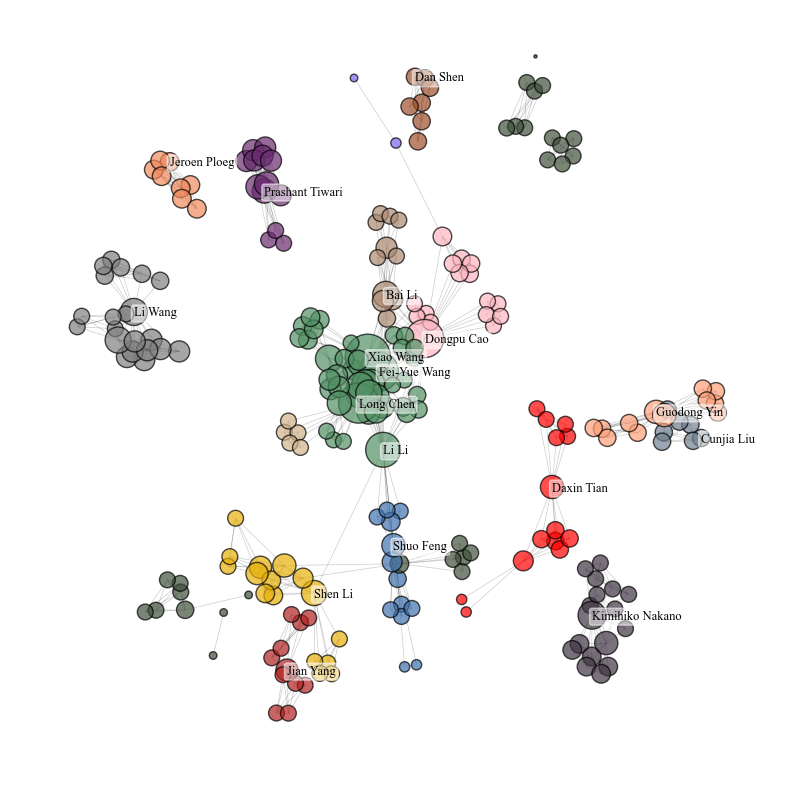

In [586]:
plot_communities2(largest_connected_subgraph, seventh_level_co_word)

In [587]:
largest_connected_subgraph.number_of_nodes(), largest_connected_subgraph.number_of_edges()

(244, 871)